In [1]:
%reload_ext autoreload
%autoreload 2
%cd ../../
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

/home/hazzu/Code/thesis


# 1. Tạo cặp genuine và imposter pairs


In [10]:
import os
import pandas as pd
import os.path as osp
from pathlib import Path
from random import shuffle

from sklearn.model_selection import train_test_split

CARDS_DIR = "datasets/cards"
SELFIES_SINGLE_DIR = "datasets/selfies_single"


def generate_genuine_pairs():
    cards_name = os.listdir(CARDS_DIR)
    students_name = os.listdir(SELFIES_SINGLE_DIR)

    genuine_pairs = []
    for card_name in cards_name:
        student_id = card_name.split("_")[0]
        card_path = osp.join(CARDS_DIR, card_name)

        filtered_student_name = list(
            filter(lambda student_name: student_id in student_name, students_name)
        )
        if len(filtered_student_name) == 0:
            continue

        student_name = filtered_student_name[0]
        student_selfie_path = osp.join(SELFIES_SINGLE_DIR, student_name)
        selfie_image = os.listdir(student_selfie_path)[0]

        genuine_pairs.append((card_path, osp.join(student_selfie_path, selfie_image)))

    return genuine_pairs


def generate_imposter_pairs(genuine_pairs):
    imposter_pairs_card = [card_path for (card_path, _) in genuine_pairs]
    imposter_pairs_selfie = [selfie_path for (_, selfie_path) in genuine_pairs]

    def check():
        results = [
            Path(selfie_path).parts[2].split("_")[0] in card_path
            for (card_path, selfie_path) in zip(
                imposter_pairs_card, imposter_pairs_selfie
            )
        ]
        return any(results)

    while check():
        shuffle(imposter_pairs_selfie)

    return list(zip(imposter_pairs_card, imposter_pairs_selfie))


def load_pairs():
    pairs_path = {
        "train": {
            "genuine_pairs": "datasets/cards_selfies/genuine_pairs_train.csv",
            "imposter_pairs": "datasets/cards_selfies/imposter_pairs_train.csv",
        },
        "test": {
            "genuine_pairs": "datasets/cards_selfies/genuine_pairs_test.csv",
            "imposter_pairs": "datasets/cards_selfies/imposter_pairs_test.csv",
        },
    }

    file_exists = all(
        [
            osp.exists(pairs_path[phase][pair_type])
            for phase in ["train", "test"]
            for pair_type in ["genuine_pairs", "imposter_pairs"]
        ]
    )

    pairs_data = {
        "train": {"genuine_pairs": None, "imposter_pairs": None},
        "test": {"genuine_pairs": None, "imposter_pairs": None},
    }
    if file_exists:
        for phase in ["train", "test"]:
            for pair_type in ["genuine_pairs", "imposter_pairs"]:
                df = pd.read_csv(pairs_path[phase][pair_type])
                pairs_data[phase][pair_type] = list(
                    zip(df["image1_path"], df["image2_path"])
                )
    else:
        genuine_pairs = generate_genuine_pairs()
        imposter_pairs = generate_imposter_pairs(genuine_pairs)

        pairs_data["train"]["genuine_pairs"], pairs_data["test"]["genuine_pairs"] = (
            train_test_split(genuine_pairs, test_size=0.5, random_state=42)
        )
        pairs_data["train"]["imposter_pairs"], pairs_data["test"]["imposter_pairs"] = (
            train_test_split(imposter_pairs, test_size=0.5, random_state=42)
        )

        for phase in ["train", "test"]:
            for pair_type in ["genuine_pairs", "imposter_pairs"]:
                df = pd.DataFrame(
                    {
                        "image1_path": [
                            image1 for (image1, _) in pairs_data[phase][pair_type]
                        ],
                        "image2_path": [
                            image2 for (_, image2) in pairs_data[phase][pair_type]
                        ],
                    }
                )
                df.to_csv(pairs_path[phase][pair_type], index=False)

    return pairs_data


pairs_data = load_pairs()

# 2. Tính cosine similarity


## 2.1. Yunet + SFace


In [14]:
from tqdm import tqdm
import os, cv2, timeit
from lib.face_detector import YuNetDetector
from lib.face_recognizer import SFaceRecognizer

face_detector = YuNetDetector()
face_recognizer = SFaceRecognizer()

os.makedirs(f"results/face-verification/yunet_sface", exist_ok=True)

for phase in ["train", "test"]:
    for pair_type in ["genuine_pairs", "imposter_pairs"]:
        pair_data = pairs_data[phase][pair_type]

        results = []
        for image1_path, image2_path in tqdm(pair_data, desc=f"{phase}/{pair_type}"):
            begin = timeit.default_timer()

            # Read images
            image1 = cv2.imread(image1_path)
            image2 = cv2.imread(image2_path)

            # Detect face in image1
            face1, scale1 = face_detector.detect_single_multiscale(image1)
            if face1 is None:
                print(f"Cannot detect face in image {image1_path}")
                continue
            scaled_image1 = cv2.resize(
                image1,
                (int(scale1 * image1.shape[1]), int(scale1 * image1.shape[0])),
            )

            # Detect face in image2
            face2, scale2 = face_detector.detect_single_multiscale(image2)
            if face2 is None:
                print(f"Cannot detect face in image {image2_path}")
                continue
            scaled_image2 = cv2.resize(
                image2,
                (int(scale2 * image2.shape[1]), int(scale2 * image2.shape[0])),
            )

            # Find similarity of two faces
            similarity = face_recognizer.match(
                scaled_image1, scaled_image2, face1, face2
            )

            # Calculate inference time
            end = timeit.default_timer()
            time = end - begin

            # Save result
            _face1 = [
                face1.bbox["x"],
                face1.bbox["y"],
                face1.bbox["w"],
                face1.bbox["h"],
            ]
            _face2 = [
                face2.bbox["x"],
                face2.bbox["y"],
                face2.bbox["w"],
                face2.bbox["h"],
            ]

            _face1 = [int(x / scale1) for x in _face1[:4]]
            _face2 = [int(x / scale2) for x in _face2[:4]]
            results.append(
                (
                    image1_path,
                    image2_path,
                    *_face1,
                    *_face2,
                    similarity,
                    time,
                )
            )

        # Save results to csv
        results_df = pd.DataFrame(
            results,
            columns=[
                "image1_path",
                "image2_path",
                "face1_x",
                "face1_y",
                "face1_w",
                "face1_h",
                "face2_x",
                "face2_y",
                "face2_w",
                "face2_h",
                "similarity",
                "inference_time",
            ],
        )

        results_df.to_csv(
            f"results/face-verification/yunet_sface/{pair_type}_{phase}.csv",
            index=False,
        )

test/imposter_pairs: 100%|██████████| 37/37 [00:23<00:00,  1.55it/s]


## 2.2. RetinaFace + ArcFace


In [35]:
from tqdm import tqdm
import os, cv2, timeit
from lib.face_detector import RetinaFaceDetector
from lib.face_recognizer import ArcFaceRecognizer

face_detector = RetinaFaceDetector()
face_recognizer = ArcFaceRecognizer()

os.makedirs(f"results/face-verification/retinaface_arcface", exist_ok=True)

for phase in ["train", "test"]:
    for pair_type in ["genuine_pairs", "imposter_pairs"]:
        pair_data = pairs_data[phase][pair_type]

        results = []
        for image1_path, image2_path in tqdm(pair_data, desc=f"{phase}/{pair_type}"):
            begin = timeit.default_timer()

            # Read images
            image1 = cv2.imread(image1_path)
            image2 = cv2.imread(image2_path)

            # Detect face in image1
            faces1 = face_detector.detect(image1)
            if len(faces1) != 1:
                print(f"Cannot detect face in image {image1_path}")
                continue
            face1 = faces1[0]

            # Detect face in image2
            faces2 = face_detector.detect(image2)
            if len(faces2) != 1:
                print(f"Cannot detect face in image {image2_path}")
                continue
            face2 = faces2[0]

            # Find similarity of two faces
            similarity = face_recognizer.match(image1, image2, face1, face2)

            # Calculate inference time
            end = timeit.default_timer()
            time = end - begin

            # Save result
            _face1 = [
                face1.bbox["x"],
                face1.bbox["y"],
                face1.bbox["w"],
                face1.bbox["h"],
            ]
            _face2 = [
                face2.bbox["x"],
                face2.bbox["y"],
                face2.bbox["w"],
                face2.bbox["h"],
            ]

            results.append(
                (
                    image1_path,
                    image2_path,
                    *_face1,
                    *_face2,
                    similarity,
                    time,
                )
            )

        # Save results to csv
        results_df = pd.DataFrame(
            results,
            columns=[
                "image1_path",
                "image2_path",
                "face1_x",
                "face1_y",
                "face1_w",
                "face1_h",
                "face2_x",
                "face2_y",
                "face2_w",
                "face2_h",
                "similarity",
                "inference_time",
            ],
        )

        results_df.to_csv(
            f"results/face-verification/retinaface_arcface/{pair_type}_{phase}.csv",
            index=False,
        )

*************** EP Error ***************
EP Error /onnxruntime_src/onnxruntime/core/providers/cuda/cuda_call.cc:129 std::conditional_t<THRW, void, onnxruntime::common::Status> onnxruntime::CudaCall(ERRTYPE, const char*, const char*, SUCCTYPE, const char*, const char*, int) [with ERRTYPE = cudaError; bool THRW = true; SUCCTYPE = cudaError; std::conditional_t<THRW, void, common::Status> = void] /onnxruntime_src/onnxruntime/core/providers/cuda/cuda_call.cc:121 std::conditional_t<THRW, void, onnxruntime::common::Status> onnxruntime::CudaCall(ERRTYPE, const char*, const char*, SUCCTYPE, const char*, const char*, int) [with ERRTYPE = cudaError; bool THRW = true; SUCCTYPE = cudaError; std::conditional_t<THRW, void, common::Status> = void] CUDA failure 100: no CUDA-capable device is detected ; GPU=-1 ; hostname=AN515-45 ; file=/onnxruntime_src/onnxruntime/core/providers/cuda/cuda_execution_provider.cc ; line=282 ; expr=cudaSetDevice(info_.device_id); 

 when using ['CUDAExecutionProvider', 'CP

train/imposter_pairs:  65%|██████▍   | 24/37 [00:08<00:04,  2.98it/s]


KeyboardInterrupt: 

# 3. Đánh giá


# 3.1. Tải kết quả


In [27]:
import pandas as pd

yunet_sface_results_path = {
    "genuine_pairs_train": "results/face-verification/yunet_sface/genuine_pairs_train.csv",
    "genuine_pairs_test": "results/face-verification/yunet_sface/genuine_pairs_test.csv",
    "imposter_pairs_train": "results/face-verification/yunet_sface/imposter_pairs_train.csv",
    "imposter_pairs_test": "results/face-verification/yunet_sface/imposter_pairs_test.csv",
}

retinaface_arcface_results_path = {
    "genuine_pairs_train": "results/face-verification/retinaface_arcface/genuine_pairs_train.csv",
    "genuine_pairs_test": "results/face-verification/retinaface_arcface/genuine_pairs_test.csv",
    "imposter_pairs_train": "results/face-verification/retinaface_arcface/imposter_pairs_train.csv",
    "imposter_pairs_test": "results/face-verification/retinaface_arcface/imposter_pairs_test.csv",
}

yunet_sface_results = {}
for key, value in yunet_sface_results_path.items():
    yunet_sface_results[key] = pd.read_csv(value)

retinaface_arcface_results = {}
for key, value in retinaface_arcface_results_path.items():
    retinaface_arcface_results[key] = pd.read_csv(value)

## 3.2. Biểu đồ FAR và FRR


In [28]:
import numpy as np
from matplotlib import pyplot as plt


def calc_far_frr(genuine_pairs_similarity, imposter_pairs_similarity, threshold: float):
    genuine_pred = genuine_pairs_similarity >= threshold
    imposter_pred = imposter_pairs_similarity >= threshold

    false_accept = np.sum(imposter_pred)
    false_reject = np.sum(genuine_pred == False)

    far = false_accept / len(imposter_pred)
    frr = false_reject / len(genuine_pred)

    return (far, frr)


def display_far_frr(genuine_pairs_similarity, imposter_pairs_similarity):
    thresholds = np.linspace(0, 1, 1000)
    far_frr = [
        calc_far_frr(genuine_pairs_similarity, imposter_pairs_similarity, threshold)
        for threshold in thresholds
    ]
    far_frr = np.array(far_frr)

    idx = (
        thresholds.shape[0] - np.argmin(np.abs(far_frr[:, 0] - far_frr[:, 1])[::-1]) - 1
    )
    thres = thresholds[idx]
    err = (far_frr[idx, 0] + far_frr[idx, 1]) / 2

    fig, ax = plt.subplots()
    ax.plot(thresholds, far_frr[:, 0], label="False Accept Rate (FAR)")
    ax.plot(thresholds, far_frr[:, 1], label="False Reject Rate (FRR)")
    ax.axvline(
        thres,
        color="red",
        linestyle="--",
        label=f"EER = {err * 100:.3f}% at {thres:.3f}",
    )
    ax.legend()
    ax.set_xlabel("Threshold")
    ax.set_ylabel("Error Rate")
    plt.show()

    return thres

### 3.2.1. YuNet + SFace - Training set


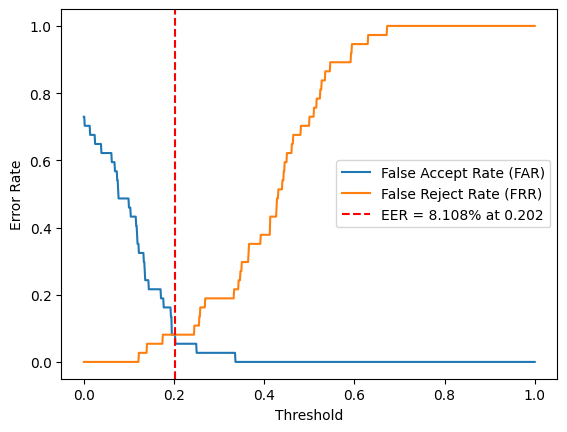

In [29]:
yunet_sface_genuine_pairs_similarity = yunet_sface_results["genuine_pairs_train"][
    "similarity"
]
yunet_sface_imposter_pairs_similarity = yunet_sface_results["imposter_pairs_train"][
    "similarity"
]

yunet_sface_threshold = display_far_frr(
    yunet_sface_genuine_pairs_similarity, yunet_sface_imposter_pairs_similarity
)

### 3.2.2. YuNet + SFace - Test set


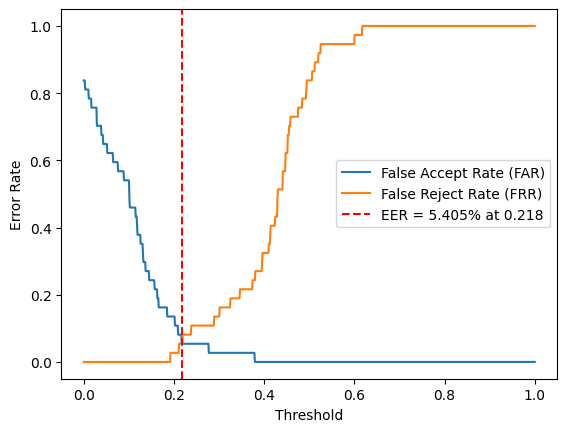

np.float64(0.2182182182182182)

In [30]:
yunet_sface_genuine_pairs_similarity = yunet_sface_results["genuine_pairs_test"][
    "similarity"
]
yunet_sface_imposter_pairs_similarity = yunet_sface_results["imposter_pairs_test"][
    "similarity"
]

display_far_frr(
    yunet_sface_genuine_pairs_similarity, yunet_sface_imposter_pairs_similarity
)

### 3.2.3. RetinaFace + ArcFace - Training set


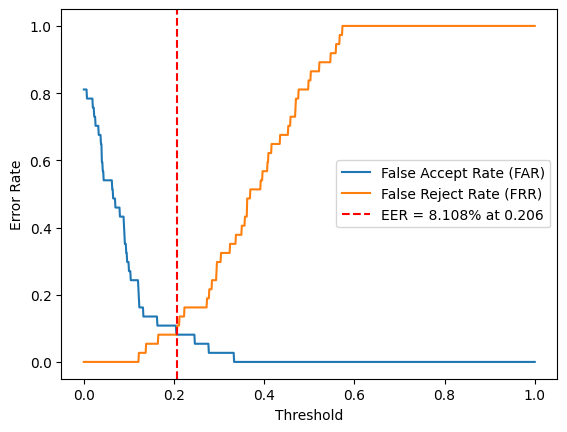

In [31]:
retinaface_arcface_genuine_pairs_similarity = retinaface_arcface_results[
    "genuine_pairs_train"
]["similarity"]
retinaface_arcface_imposter_pairs_similarity = retinaface_arcface_results[
    "imposter_pairs_train"
]["similarity"]

retinaface_arcface_threshold = display_far_frr(
    retinaface_arcface_genuine_pairs_similarity,
    retinaface_arcface_imposter_pairs_similarity,
)

### 3.2.4. RetinaFace + ArcFace - Test set


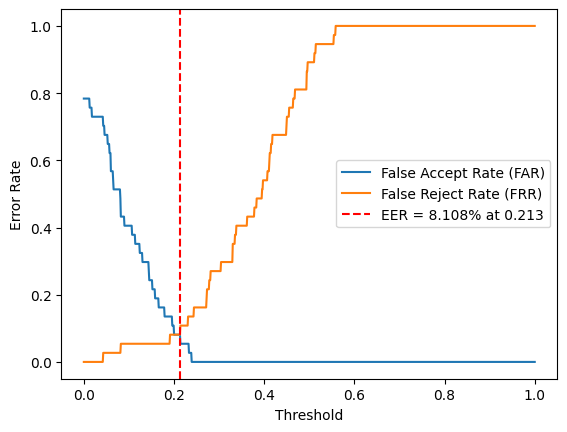

np.float64(0.2132132132132132)

In [26]:
retinaface_arcface_genuine_pairs_similarity = retinaface_arcface_results[
    "genuine_pairs_test"
]["similarity"]
retinaface_arcface_imposter_pairs_similarity = retinaface_arcface_results[
    "imposter_pairs_test"
]["similarity"]

display_far_frr(
    retinaface_arcface_genuine_pairs_similarity,
    retinaface_arcface_imposter_pairs_similarity,
)

## 3.3. ROC + AUC


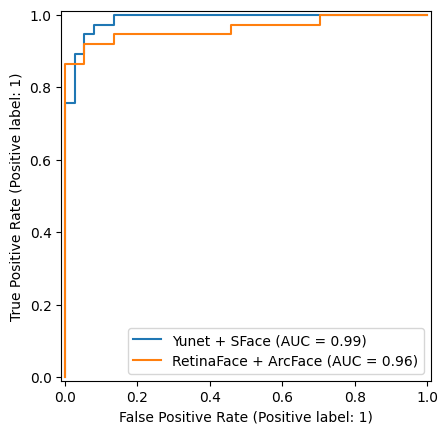

In [32]:
from matplotlib import pyplot as plt
from sklearn.metrics import RocCurveDisplay

yunet_sface_y_true = [1] * len(yunet_sface_results["genuine_pairs_test"]) + [0] * len(
    yunet_sface_results["imposter_pairs_test"]
)
yunet_sface_y_score = [
    *yunet_sface_results["genuine_pairs_test"]["similarity"],
    *yunet_sface_results["imposter_pairs_test"]["similarity"],
]

retinaface_arcface_y_true = [1] * len(
    retinaface_arcface_results["genuine_pairs_test"]
) + [0] * len(retinaface_arcface_results["imposter_pairs_test"])
retinaface_arcface_y_score = [
    *retinaface_arcface_results["genuine_pairs_test"]["similarity"],
    *retinaface_arcface_results["imposter_pairs_test"]["similarity"],
]

fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(
    yunet_sface_y_true, yunet_sface_y_score, name="Yunet + SFace", ax=ax
)
RocCurveDisplay.from_predictions(
    retinaface_arcface_y_true,
    retinaface_arcface_y_score,
    name="RetinaFace + ArcFace",
    ax=ax,
)

plt.show()

## 3.4. Inference time


In [34]:
import numpy as np

yunet_sface_inference_time = np.concatenate(
    [
        yunet_sface_results["genuine_pairs_train"]["inference_time"].values,
        yunet_sface_results["imposter_pairs_train"]["inference_time"].values,
    ]
).mean()

retinaface_arcface_inference_time = np.concatenate(
    [
        retinaface_arcface_results["genuine_pairs_train"]["inference_time"].values,
        retinaface_arcface_results["imposter_pairs_train"]["inference_time"].values,
    ]
).mean()

print(f"Yunet + SFace Inference Time: {yunet_sface_inference_time * 1000:.3f} ms")
print(
    f"RetinaFace + ArcFace Inference Time: {retinaface_arcface_inference_time * 1000:.3f} ms"
)

Yunet + SFace Inference Time: 524.667 ms
RetinaFace + ArcFace Inference Time: 321.810 ms
